# Data import

In [1]:
%autosave 60
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from matplotlib import cm
from sklearn.preprocessing import OneHotEncoder


Autosaving every 60 seconds


In [397]:
data=pd.read_csv('train2.csv')

In [398]:
data2=data

# Data description

In [604]:
data.head()

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,datasplit,campaign,...,language,screenColors,screenResolution,deviceCategory,criteriaParameters,page,slot,gclId,adNetworkType,isVideoAd
0,Organic Search,2016-09-02,1131660440785968503,1131660440785968503_1472830385,Not Socially Engaged,1472830385,1,1472830385,train,(not set),...,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,NaN,NaN,NaN,NaN,NaN
1,Organic Search,2016-09-02,377306020877927890,377306020877927890_1472880147,Not Socially Engaged,1472880147,1,1472880147,train,(not set),...,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,NaN,NaN,NaN,NaN,NaN
2,Organic Search,2016-09-02,3895546263509774583,3895546263509774583_1472865386,Not Socially Engaged,1472865386,1,1472865386,train,(not set),...,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,NaN,NaN,NaN,NaN,NaN
3,Organic Search,2016-09-02,4763447161404445595,4763447161404445595_1472881213,Not Socially Engaged,1472881213,1,1472881213,train,(not set),...,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,NaN,NaN,NaN,NaN,NaN
4,Organic Search,2016-09-02,27294437909732085,27294437909732085_1472822600,Not Socially Engaged,1472822600,2,1472822600,train,(not set),...,not available in demo dataset,not available in demo dataset,not available in demo dataset,mobile,not available in demo dataset,NaN,NaN,NaN,NaN,NaN


In [403]:
data.dtypes.unique()

array([dtype('O'), dtype('int64'), dtype('float64'), dtype('bool')],
      dtype=object)

In [404]:
quantitative = [_ for _ in data.columns if (data.dtypes[_] != 'object' and data.dtypes[_] != 'bool')]
qualitative = [_ for _ in data.columns if (data.dtypes[_] == 'object' or data.dtypes[_] == 'bool')]


On souhaite prédire la variable **transactionRevenue**. <p>

Pour cela, on dispose du jeu de données data qui contient 903653 observations et 55 variables dont 12 quantitatives et 43 qualitatives :


*   **Quantitative** : date, visitId, visitNumber, visitStartTime, visits, hits, pageviews, bounces, newVisits, isMobile,page, transactionRevenue
*   **Qualitative** : channelGrouping, fullVisitorId, sessionId, socialEngagementType, datasplit, campaign, source, medium, keyword, isTrueDirect, referralPath, adContent, continent, subContinent, country, region, metro, city, cityId, networkDomain, latitude, longitude, networkLocation, browser, browserVersion, browserSize, operatingSystem, operatingSystemVersion, mobileDeviceBranding, mobileDeviceModel, mobileInputSelector, mobileDeviceInfo, mobileDeviceMarketingName, flashVersion, language, screenColors, screenResolution, deviceCategory, criteriaParameters, slot, gclId, adNetworkType, isVideoAd



Ainsi, le but est de choisir le meilleur modèle de prédiction pas forcement avec les meilleures performances mais plutot avec une approche structurée et réflechie pour résoudre le problème.<p>

Il s'agit d'un problème de **régression** avec comme métrique R².
Plus la valeur du R² s'approche de 1, plus le modèle est précis.

# Data cleaning

## Target

In [405]:
data["transactionRevenue"].isnull().sum()/data.shape[0]

0.9872572768529513

98,7% des valeurs de la variable transactionRevenue sont nulles <p>
Ainsi, seul un faible pourcentage de client produit la plupart du revenue.

In [406]:
test=data.groupby('fullVisitorId').sum()['transactionRevenue']
test = data.groupby('fullVisitorId')['transactionRevenue'].agg(['sum','count'])
test.columns=['transactionRevenueTotal','NombreVisiteavecRevenue']

In [407]:
data["transactionRevenue"] = data["transactionRevenue"].fillna(0)
test['NombreVisiteTotal']=data.groupby('fullVisitorId')['transactionRevenue'].count()

In [408]:
data=pd.merge(data, test, on='fullVisitorId')

## Valeurs manquantes

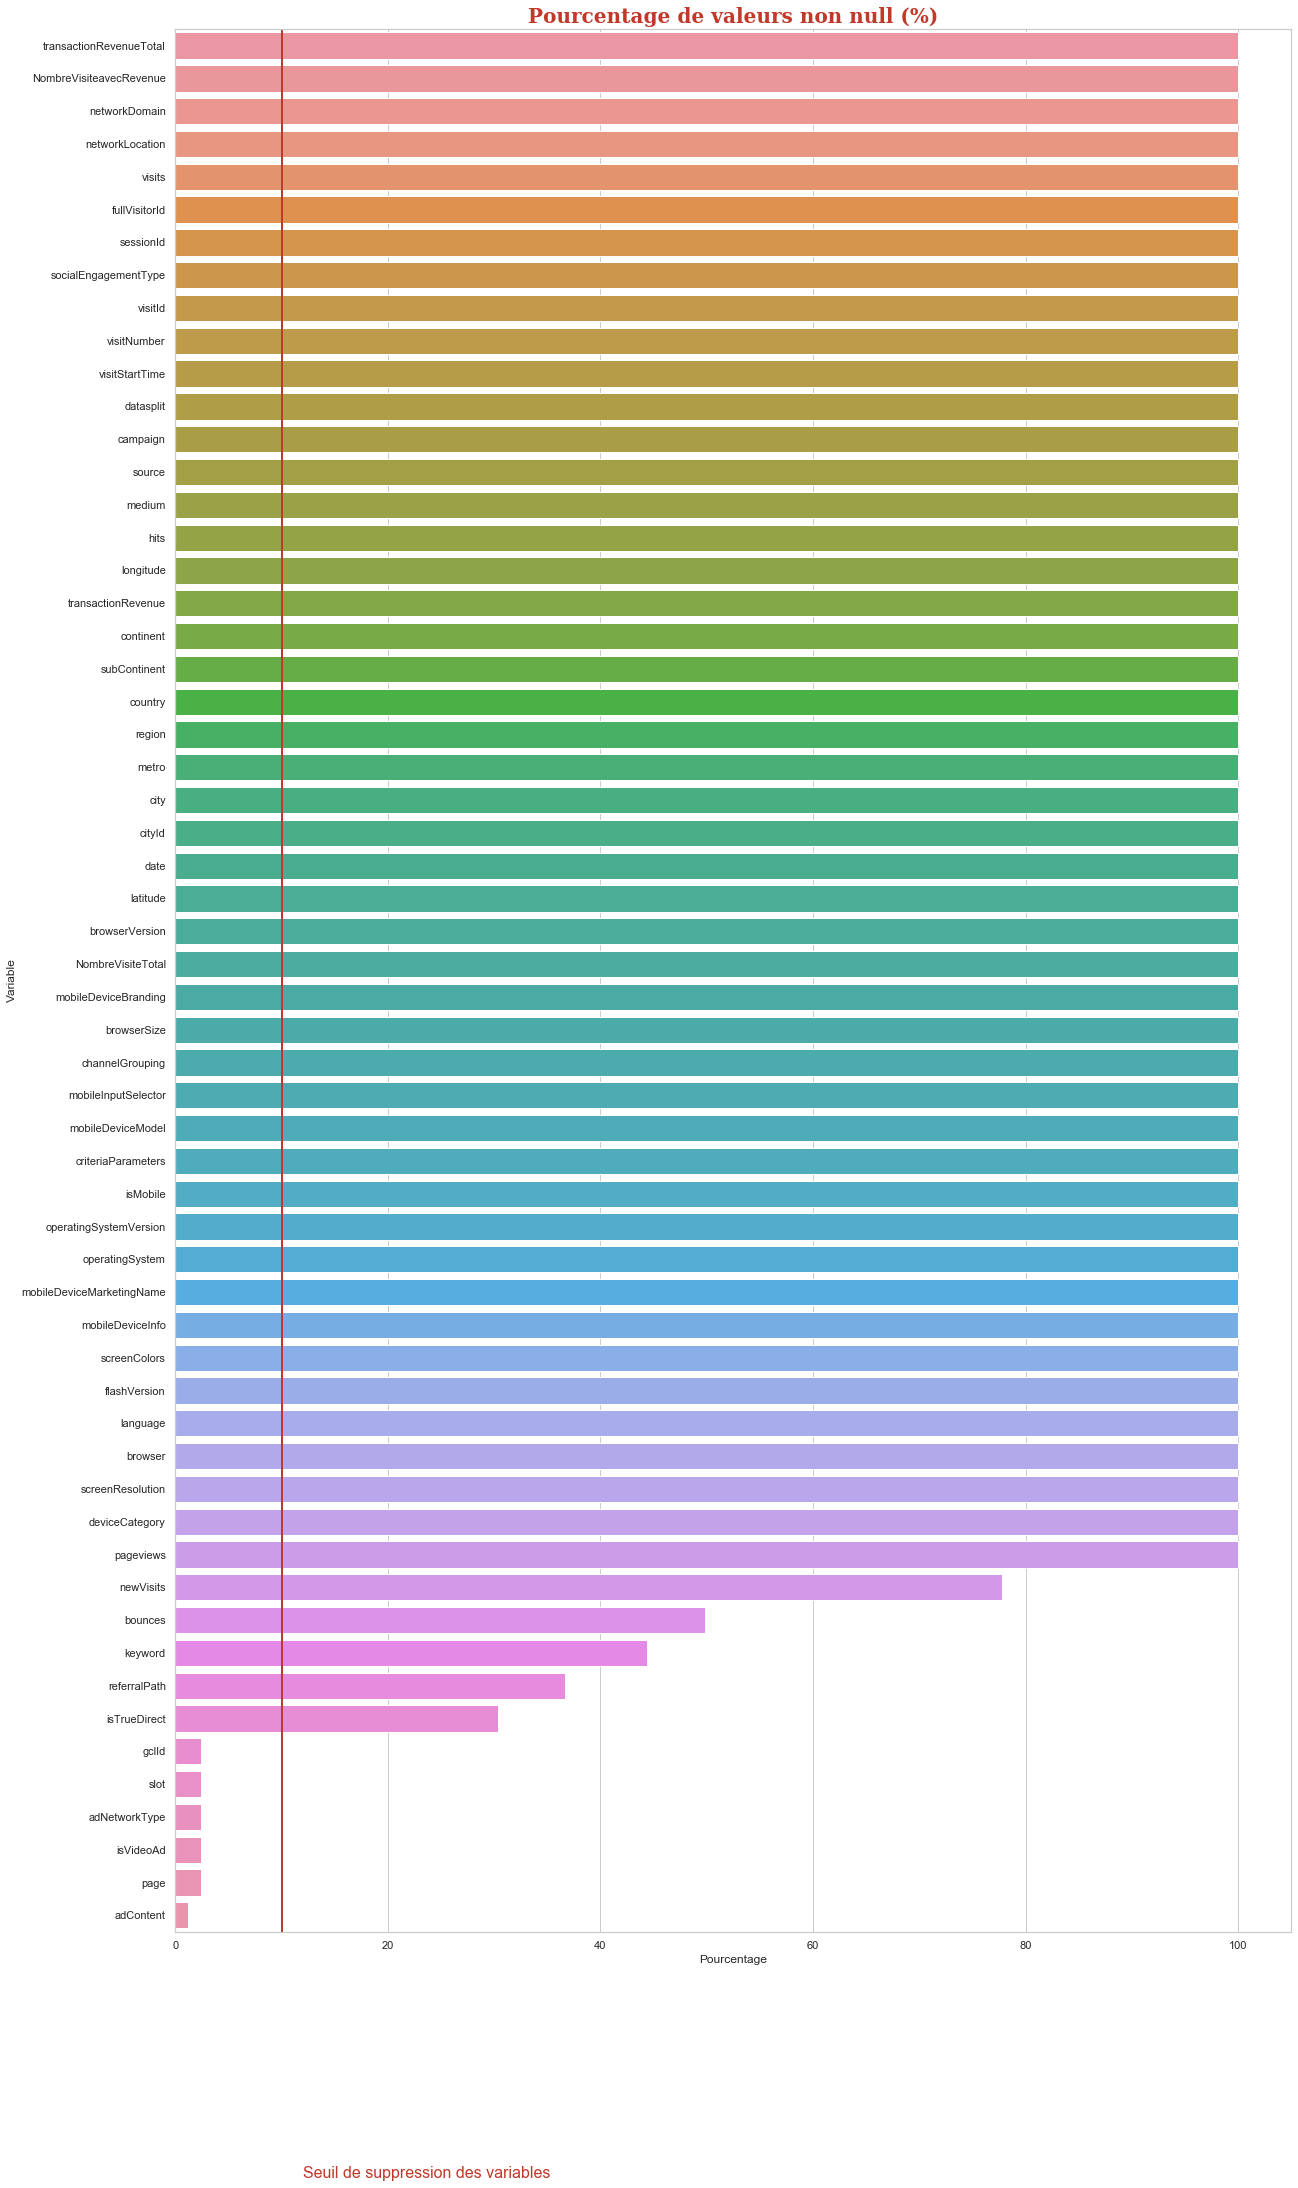

In [409]:
def nb_null(df, taux):
  x = ((df.isnull().sum() / df.shape[0])*100).sort_values(ascending=False).reset_index()
  x.columns = ['Variable','Pourcentage']
  y = x[x.Pourcentage >=taux]
  return y
df_2 = nb_null(data, 0)
df_2["Pourcentage"] = 100-df_2["Pourcentage"]
df_2 = df_2.sort_values("Pourcentage", ascending=False) 
seuil = 10
fig = plt.figure(figsize=(20, 35))
font_title = {'family': 'serif','color':'#C0392B','weight': 'bold','size': 20,}
sns.barplot(data=df_2,x="Pourcentage", y="Variable")
plt.axvline(x=seuil, linewidth=2, color = '#C0392B')
plt.text(seuil+2, 65, 'Seuil de suppression des variables', fontsize = 16, color = '#C0392B')
plt.title("Pourcentage de valeurs non null (%)", fontdict=font_title)
plt.show()

11 variables ont des valeurs manquantes dont 6 avec un taux de + de 95%. <p>
On decide de les retirer de notre étude.

In [410]:
selected_col= list(df_2.loc[df_2['Pourcentage']>=seuil, 'Variable'].values)

In [411]:
data = data[selected_col]

#### Variable *referralPath*

In [412]:
#Il y a 1475 valeurs uniques de la variable referralPath donc on décide de supprimer cette colonne
data = data.drop(columns = ["referralPath"])

#### Not available in demo dataset	

In [413]:
#On va supprimer toutes les colonnes qui n'ont qu'une valeur

In [414]:
#On va supprimer toutes les colonnes qui n'ont qu'une valeur
liste_col=[]
for col in data.columns:
    if len(data[col].unique())==1 :
        liste_col.append(col)

In [415]:
data = data.drop(columns = liste_col)
data= data.reset_index(drop=True)

In [416]:
data.columns

Index(['transactionRevenueTotal', 'NombreVisiteavecRevenue', 'networkDomain',
       'fullVisitorId', 'sessionId', 'visitId', 'visitNumber',
       'visitStartTime', 'campaign', 'source', 'medium', 'hits',
       'transactionRevenue', 'continent', 'subContinent', 'country', 'region',
       'metro', 'city', 'date', 'NombreVisiteTotal', 'channelGrouping',
       'isMobile', 'operatingSystem', 'browser', 'deviceCategory', 'pageviews',
       'newVisits', 'bounces', 'keyword', 'isTrueDirect'],
      dtype='object')

#### Variable *campaign*

In [417]:
data["campaign"].value_counts()
data["campaign"] = data["campaign"].replace({"(not set)": "None"})
data["campaign"] = data["campaign"].replace({"(none)": "None"})

data2["campaign"] = data2["campaign"].replace({"(not set)": "None"})
data2["campaign"] = data2["campaign"].replace({"(none)": "None"})

In [20]:
#On regarde les compagnie où il ya eu de la visite et le nombre de transaction par compagnie

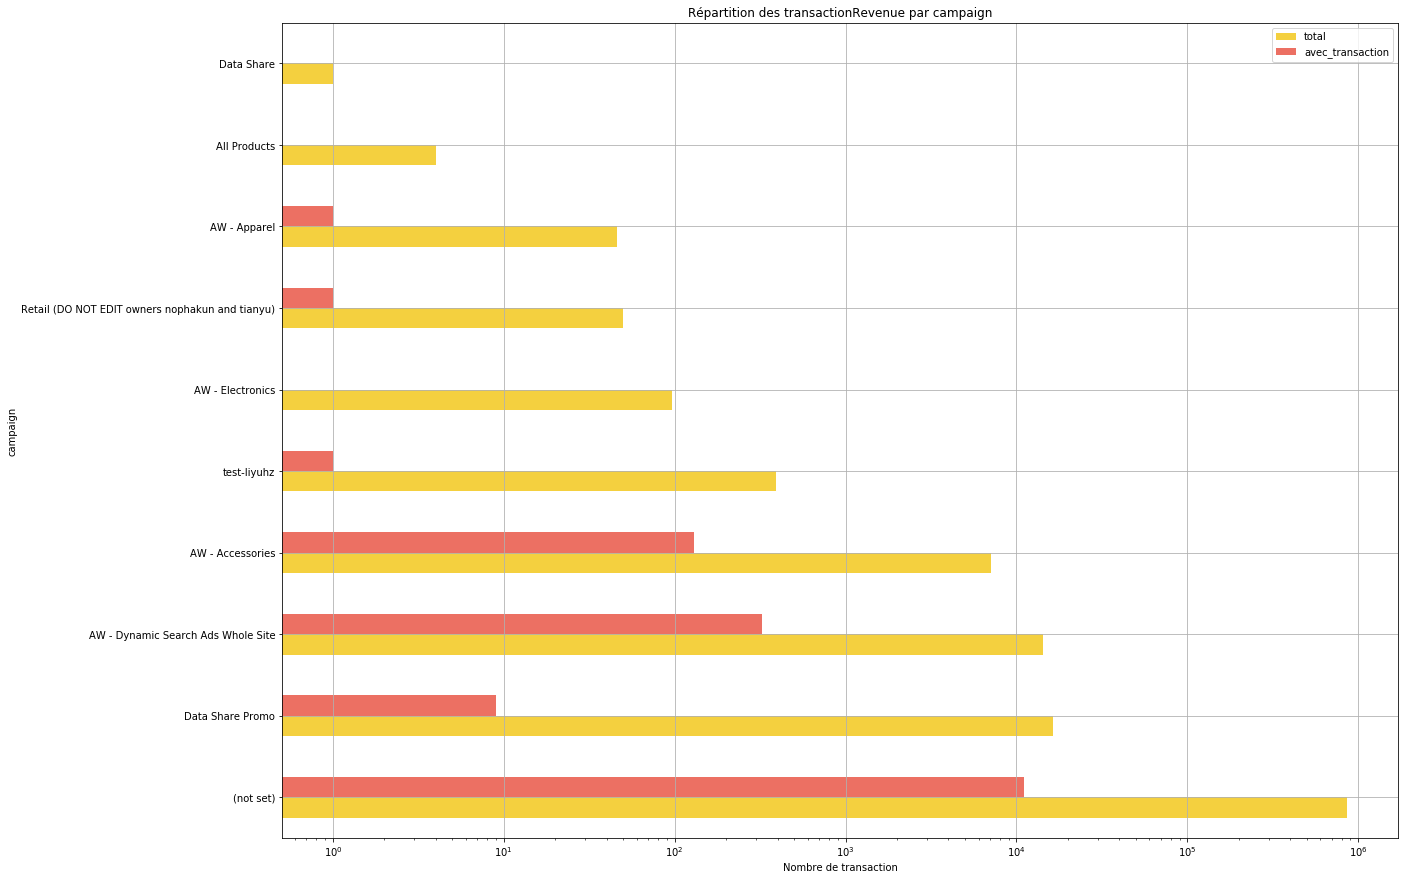

In [48]:
df_campaign = data.groupby('campaign')['transactionRevenue'].agg(['size','count']).sort_values(['size','count'], ascending=False)
df_campaign.columns = ['total','avec_transaction']
df_campaign = df_campaign.sort_values(by=['total','campaign'],ascending=False)
df_campaign.plot(kind='barh',logx=True,grid=True,figsize=(20,15), color=["#F4D03F","#EC7063"])
#sns.barplot(data=df_campaign,x="total",y="avec_transaction", palette="Blues_d")
plt.title("Répartition des transactionRevenue par campaign")
plt.xlabel('Nombre de transaction')
plt.show()

In [288]:
#On voit que la majorité des transaction sont effectué dans une campagne non defini donc 
# on peut soit regrouper les valeurs soit se passer de cette colonne

In [418]:
data=data.drop(['campaign'],axis=1)

#### Variable *channelGrouping*

In [419]:
data["channelGrouping"].unique()

array(['Organic Search', 'Referral', 'Paid Search', 'Affiliates',
       'Direct', 'Display', 'Social', '(Other)'], dtype=object)

#### Variable *medium*

In [420]:
data["medium"].unique()

array(['organic', 'referral', 'cpc', 'affiliate', '(none)', 'cpm',
       '(not set)'], dtype=object)

In [421]:
data["medium"] = data["medium"].replace({"(not set)": "None"})
data["medium"] = data["medium"].replace({"(none)": "None"})

#### Variable *visitStartTime*

In [422]:
data['date'] = pd.to_datetime(data['date'], format = '%Y%m%d')
data["visitStartTime"] = pd.to_datetime(data["visitStartTime"],unit='s')

In [423]:
data['visitStartDay']=pd.to_datetime(data['visitStartTime']).dt.day
data['visitStartMonth']=pd.to_datetime(data['visitStartTime']).dt.month
data["visitStartYear"]=pd.to_datetime(data['visitStartTime']).dt.year
data['visitStartDayOfWeek']= pd.to_datetime(data['visitStartTime']).dt.weekday

In [424]:
data['WeekEnd'] = data['visitStartDayOfWeek'].apply(lambda x: 1 if x > 4 else 0)
data['Journée'] = data.apply(lambda x : days[x['date'].dayofweek], axis = 1)

In [425]:
# Regrouper les sources en 4 catégories : google, youtube, direct et autre 
data['source'] =data['source'].apply(lambda x : 'google' if 'google' in x 
                                      else ('youtube' if 'youtube' in x 
                                            else ('direct' if 'direct' in x
                                                  else 'autre')))

#### Variable *deviceCategory*

In [426]:
data["deviceCategory"].unique()

array(['desktop', 'mobile', 'tablet'], dtype=object)

#### Variable *networkDomain*

In [427]:
data["networkDomain"] = data["networkDomain"].replace({"(not set)": "None"})

In [429]:
data["networkDomain"].value_counts()

None                244881
unknown.unknown     146034
comcast.net          28743
rr.com               14827
verizon.net          13637
                     ...  
hanacke.net              1
flexoffers.com           1
walkermedia.com          1
patientfirst.com         1
spils.lv                 1
Name: networkDomain, Length: 28064, dtype: int64

In [430]:
data=data.drop(["networkDomain"],axis=1)

#### Variable *hits*

In [231]:
data["hits"].value_counts()

1      446754
2      137952
3       70402
4       42444
5       30939
        ...  
250         1
251         1
259         1
262         1
244         1
Name: hits, Length: 274, dtype: int64

#### Variable géographique (continent, subcontinent ...)

In [431]:
data["continent"] = data["continent"].replace({"(not set)": "None"})
data["subContinent"] = data["subContinent"].replace({"(not set)": "None"})
data["country"] = data["country"].replace({"(not set)": "None"})
data["region"] = data["region"].replace({'not available in demo dataset': "None"})
data["region"] = data["region"].replace({"(not set)": "None"})
data["city"] = data["city"].replace({'(not set)': "None"})
data["city"] = data["city"].replace({'not available in demo dataset': "None"})

In [432]:
#On ne garde pas l'information sur la région car 60% des valeurs sont manquantes
#data=data.drop(["region"],axis=1)

#### Variable *metro*

In [433]:
data["metro"] = data["metro"].replace({'(not set)': "None"})
data["metro"] = data["metro"].replace({'not available in demo dataset': "None"})
data=data.drop(columns = ["metro"]).reset_index(drop=True)

#### Variable *isMobile*

In [434]:
data["isMobile"] = data["isMobile"]*1
data["isMobile"].value_counts()

0    664530
1    239123
Name: isMobile, dtype: int64

#### Variable *operatingSystem*

In [435]:
data["operatingSystem"] = data["operatingSystem"].replace({'(not set)': "None"})

In [436]:
# Regrouper les operateurs en 5 catégories : Windows, Macintosh, Android, Linus et autre 
data["operatingSystem"] =data['operatingSystem'].apply(lambda x : 'Windows' if 'Windows' in x 
                                                       else ('Macintosh' if 'Macintosh' in x 
                                                             else ('Android' if 'Android' in x 
                                                                  else('Linux' if 'Linux' in x else 'AutreOperateur'))))

#### Variable *browser*

In [437]:
# regrouper les navigateurs en catégorie 
data["browser"] =data["browser"].apply(lambda x : 'Chrome' if 'Chrome' in x 
                                                       else ('Safari' if 'Safari' in x 
                                                             else ('Firefox' if 'Firefox'in x 
                                                                  else('Internet Explorer' if 'Internet Explorer'
                                                                       else('Edge' if 'Edge' in x else 'AutreBrowser')))))

#### Variable *pageviews*, *newVisits* et *bounces*

In [438]:
data["pageviews"] = data["pageviews"].fillna(0)
data["newVisits"] = data["newVisits"].fillna(0)
data["bounces"] = data["bounces"].fillna(0)

#### Variable *keyword*

In [439]:
data["keyword"] = data["keyword"].replace({'(not provided)': "None"})
data["keyword"] = data["keyword"].fillna("None")

In [440]:
#Un nombre trop grand de différentes variables donc on supprime la colonne
data=data.drop(["keyword"], axis=1)


#### Variable *isTrueDirect*

In [441]:
data["isTrueDirect"] = data["isTrueDirect"].fillna("None")
data["isTrueDirect"] = data["isTrueDirect"].replace({'None': 0})
data["isTrueDirect"] = data["isTrueDirect"].replace({True: 1})

## Data visualization

### Données géographiques

In [442]:
def top_words(df, column, nb_top):
    count_keyword = dict()
    for index, col in df[column].iteritems():
        if isinstance(col, float):
            continue
        for word in col.split(','):
            if word in count_keyword.keys():
                count_keyword[word] += 1
            else :
                count_keyword[word] = 1
    keyword_top = []
    for k,v in count_keyword.items():
        keyword_top.append([k,v])
    keyword_top.sort(key = lambda x:x[1], reverse = True)
    return keyword_top[:nb_top]

In [445]:
data3 = data.loc[data["transactionRevenue"] >0].reset_index(drop=True)
data3.head(3)

,transactionRevenueTotal,NombreVisiteavecRevenue,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,source,medium,hits,...,pageviews,newVisits,bounces,isTrueDirect,visitStartDay,visitStartMonth,visitStartYear,visitStartDayOfWeek,WeekEnd,Journée
0,1.231500e+08,1,5442500961218255804,5442500961218255804_1477276680,1477276680,5,2016-10-24 02:38:00,google,referral,51,...,38.0,0.0,0.0,1,24,10,2016,0,0,Dimanche
1,2.250000e+08,1,780206376162514125,0780206376162514125_1473373023,1473373023,4,2016-09-08 22:17:03,google,referral,132,...,92.0,0.0,0.0,1,8,9,2016,3,0,Jeudi
2,3.254370e+09,8,8436426603099391262,8436426603099391262_1479954329,1479954329,37,2016-11-24 02:25:29,google,referral,13,...,11.0,0.0,0.0,0,24,11,2016,3,0,Mercredi


In [336]:
df_cont = pd.DataFrame(top_words(df=data3, column="subContinent", nb_top=len(data3["subContinent"].unique())), columns=["subContinent","Nombre"])
df_cont

,subContinent,Nombre
0,Northern America,11143
1,South America,98
2,Eastern Asia,59
3,Southeast Asia,32
4,Western Europe,30
5,Northern Europe,27
6,Central America,26
7,Western Asia,21
8,Caribbean,16
9,Australasia,14


In [339]:
df_sub_cont =data3[['continent', 'subContinent']].drop_duplicates(subset=['continent', 'subContinent']).reset_index(drop=True)
df_sub_cont

,continent,subContinent
0,Americas,Northern America
1,Americas,South America
2,Europe,Northern Europe
3,Africa,Eastern Africa
4,Asia,Eastern Asia
5,Americas,Caribbean
6,Americas,Central America
7,Oceania,Australasia
8,Europe,Western Europe
9,Asia,Southeast Asia


In [340]:
df3=data3.groupby('subContinent').count()["sessionId"]

In [341]:
df4=pd.merge(df_sub_cont, df3, on='subContinent').groupby(['continent', 'subContinent','sessionId']).size().reset_index().iloc[:,:-1]

In [342]:
df4 = df4.pivot_table('sessionId', ['continent', 'subContinent'])
df4 = df4.drop(["None"])
df4

sessionId
continent subContinent               
Africa    Eastern Africa            3
          Northern Africa           1
          Southern Africa           2
          Western Africa            2
Americas  Caribbean                16
          Central America          26
          Northern America      11143
          South America            98
Asia      Central Asia              2
          Eastern Asia             59
          Southeast Asia           32
          Southern Asia            11
          Western Asia             21
Europe    Eastern Europe           14
          Northern Europe          27
          Southern Europe           8
          Western Europe           30
Oceania   Australasia              14

On remarque ici un nombre de transaction beaucoup trop grand pour l'amérique du nord, comparé aux autres sous continons. Nous notons cet écart mais souhaitons tout de même observer la répartition des transactions dans les autres sous conntinent.  

In [347]:
indexNames = df_sub_cont[ df_sub_cont["subContinent"]=="Northern America"].index
df_sub_cont.drop(indexNames , inplace=True)
#df4 = df4.drop(["Americas"])

In [349]:
df4=pd.merge(df_sub_cont, df3, on='subContinent').groupby(['continent', 'subContinent','sessionId']).size().reset_index().iloc[:,:-1]
df4 = df4.pivot_table('sessionId', ['continent', 'subContinent'])
df4 = df4.drop(["None"])

In [350]:
liste=['Africa', 'Americas','Asia', 'Europe', 'Oceania']

In [351]:
##### A supprimer si non utilisé
facecolor = '#eaeaf2'
font_color = '#525252'
hfont = {'fontname':'Calibri'}
labels = liste
size = 0.3
vals = df4['sessionId']

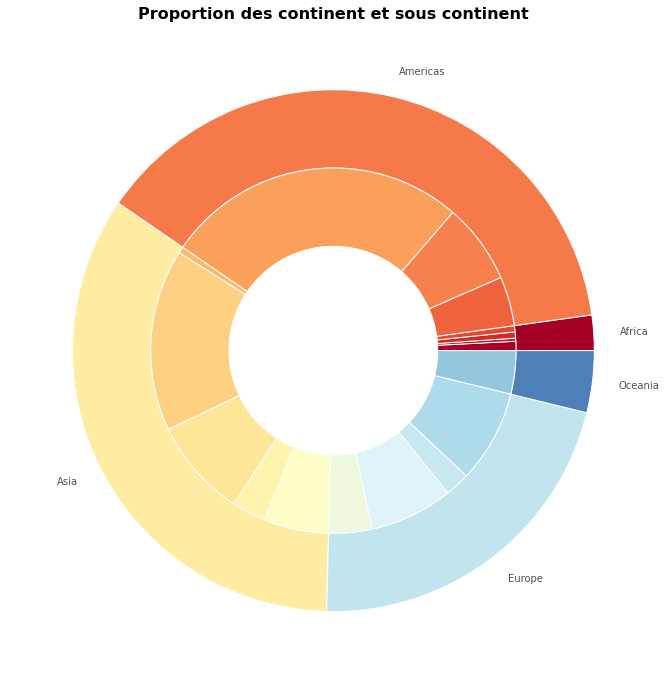

In [373]:
fig, ax = plt.subplots(figsize=(20,12))
size = 0.3
group_sum = df4.groupby('continent')['sessionId'].sum()
labels = liste

ax.pie(group_sum, radius=1,
       labels=labels,
       colors = cm.RdYlBu(np.arange(250)[list(np.int64(np.linspace(0, 225, 5)))]),      
       textprops={'color':font_color}, 
       wedgeprops=dict(width=size, edgecolor='w',))

ax.pie(vals, radius=1-size,
       colors =cm.RdYlBu(np.arange(250)[list(np.int64(np.linspace(0, 225, 20)))]), 
       wedgeprops=dict(width=size, edgecolor='w'))

ax.set_title('Proportion des continent et sous continent', loc ='center', fontsize=16,fontweight='bold' )
plt.show()

Après l'Amérique du nord on remarque que les autres sous continant de l'Amerique et l'asie, suivis de l'europe sont les zones géographiques comptant le plus de transaction avec revenues. 

In [374]:
df_top_country = pd.DataFrame(top_words(df=data3, column="country", nb_top=20), columns=["Country","Nombre"])
df_top_region = pd.DataFrame(top_words(df=data3, column="region", nb_top=20), columns=["Region","Nombre"])
df_top_city = pd.DataFrame(top_words(df=data3, column="city", nb_top=20), columns=["City","Nombre"])

In [382]:
from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

In [385]:
display_side_by_side(df_top_country,df_top_region,df_top_city)

,Country,Nombre
0,United States,10953
1,Canada,190
2,Venezuela,63
3,Mexico,20
4,Taiwan,19
5,Japan,17
6,United Kingdom,16
7,Australia,13
8,Puerto Rico,11
9,Indonesia,11


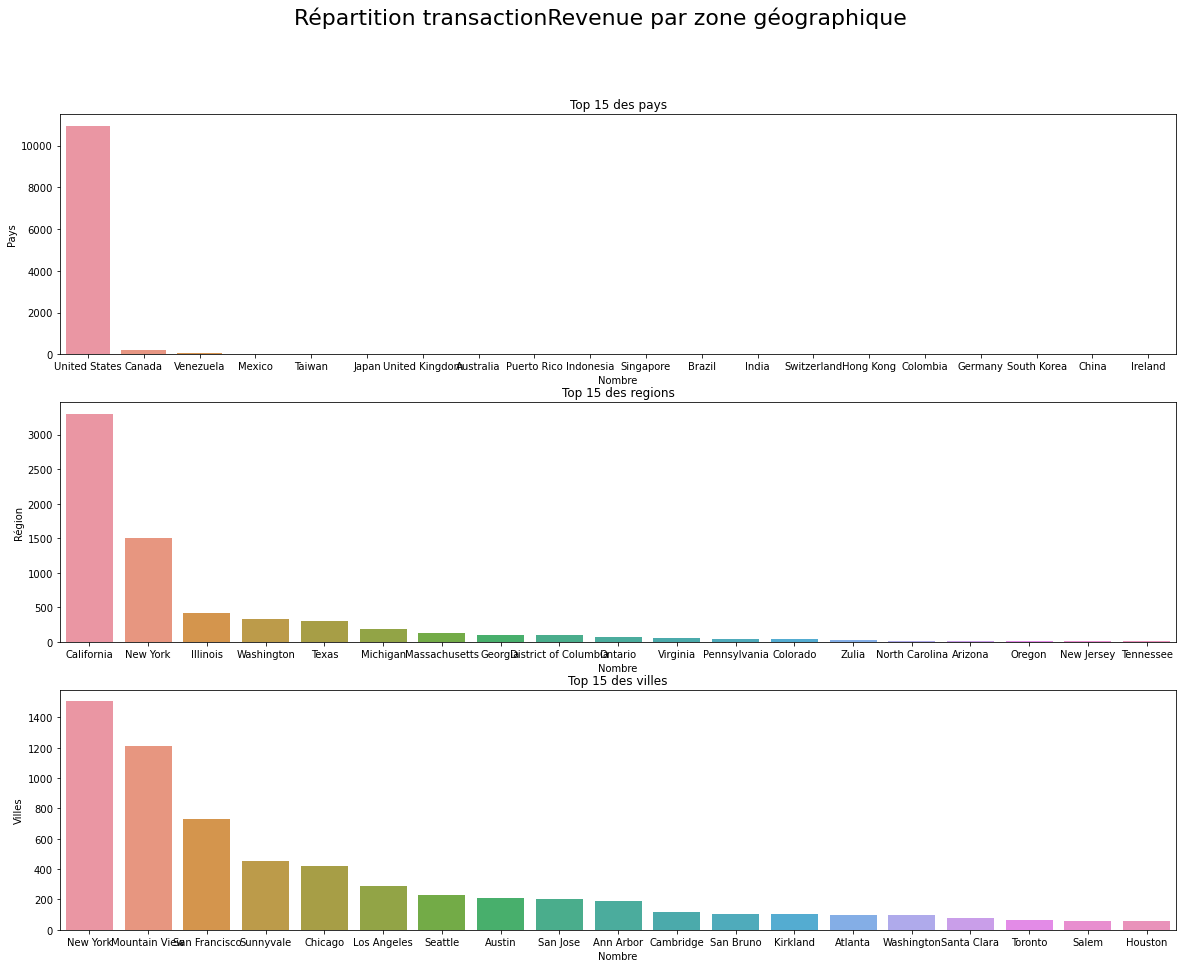

In [386]:
fig, axes = plt.subplots(3, 1, sharex=False, sharey=False, figsize=(20,15))
fig.suptitle(r"Répartition transactionRevenue par zone géographique" "\n", fontsize=22)

sns.barplot(y=df_top_country["Nombre"], x=df_top_country["Country"], orient = 'v',ax=axes[0])
axes[0].set_title('Top 20 des pays')
axes[0].set_xlabel("Nombre")
axes[0].set_ylabel("Pays")

sns.barplot(y=df_top_region["Nombre"], x=df_top_region["Region"], orient = 'v',ax=axes[1])
axes[1].set_title('Top 20 des regions')
axes[1].set_xlabel("Nombre")
axes[1].set_ylabel("Région")

sns.barplot(y=df_top_city["Nombre"], x=df_top_city["City"], orient = 'v',ax=axes[2])
axes[2].set_title('Top 20 des villes')
axes[2].set_xlabel("Nombre")
axes[2].set_ylabel("Villes")

plt.show()

Nous remarquons qu'aux USA nous comptons un nombre très supérieurs aux autres pays de transaction générant un revenu. Ce nombre est tellement grand que nous avons quasiment pas la visibilité sur les autres pays. Regardons la répartition des autres pays (top 20) qui suivent les usa

<AxesSubplot:xlabel='Country', ylabel='Nombre'>

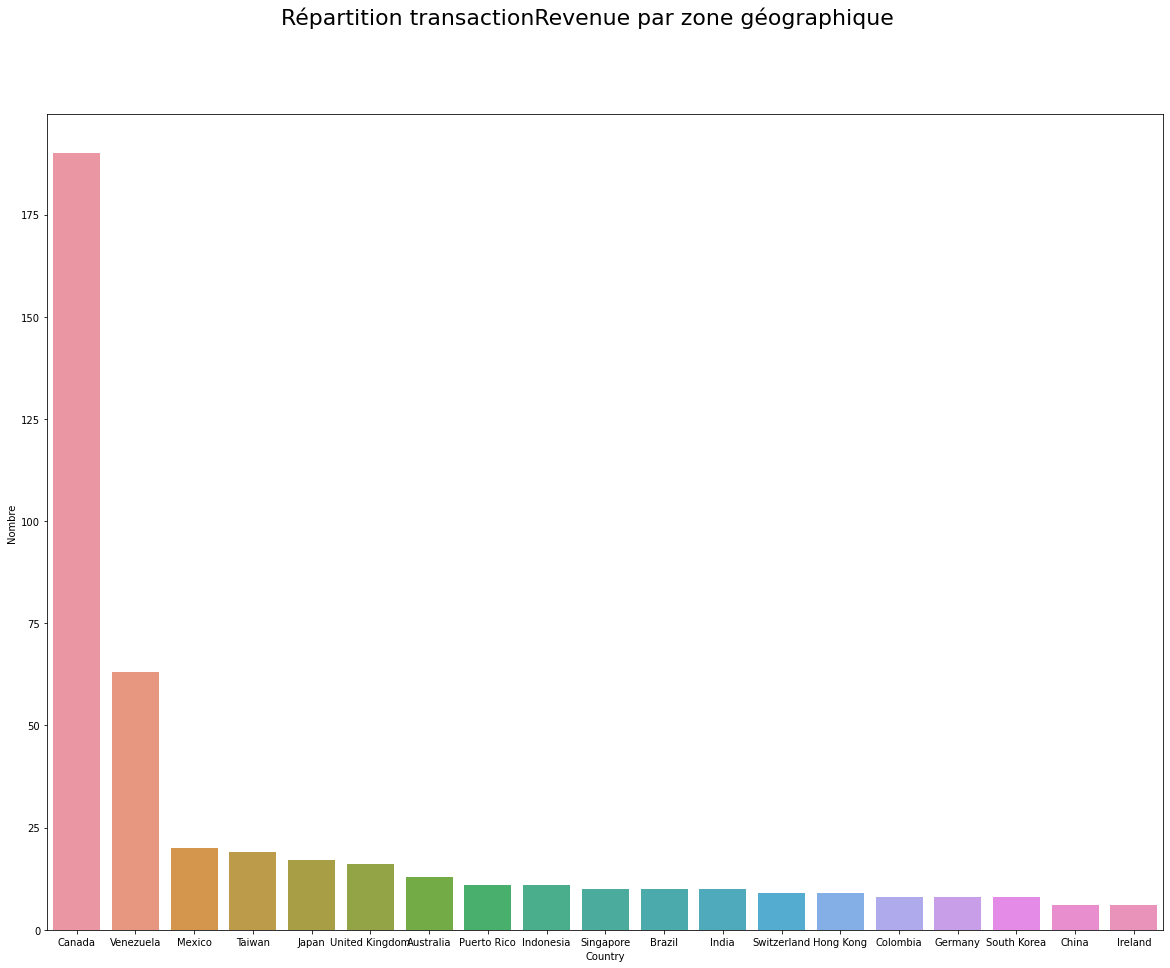

In [392]:
df_top_country = df_top_country.drop([0]).reset_index(drop=True)
fig, axes = plt.subplots(figsize=(20,15))
fig.suptitle(r"Répartition transactionRevenue par zone géographique" "\n", fontsize=22)

sns.barplot(y=df_top_country["Nombre"], x=df_top_country["Country"], orient = 'v')

In [446]:
data=data.drop(['region'],axis=1)

In [447]:
data=data.drop(['country'],axis=1)
data=data.drop(['city'],axis=1)

In [448]:
def fct(x):
    if x in ["Northern America","Southeast Asia","Southern Asia","Western Europe","Northern Europe","Eastern Asia","Eastern Europe","Western Asia","South America","Southern Europe"]:
        return x
    else:
        return "AutreSousContinent"

In [449]:
data["subContinent"]=data["subContinent"].apply(lambda x:fct(x))

### Données temporelles

In [450]:
new = data.loc[data["transactionRevenueTotal"]>0]
new2 = data.loc[data["transactionRevenue"]>0]

In [451]:
days = {0 : 'Lundi',
        1 : 'Mardi',
        2 : 'Mercredi',
        3 : 'Jeudi',
        4 : 'Vendredi',
        5 : 'Samedi',
        6 : 'Dimanche'}

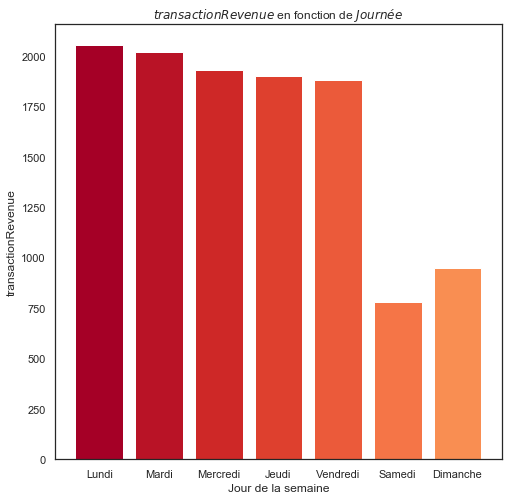

In [274]:
plt.figure(figsize = (8, 8))
plt.bar(new2.groupby('Journée').count()['transactionRevenue'].loc[days.values()].index, new2.groupby('Journée').count()['transactionRevenue'].loc[days.values()], color = cm.RdYlBu(np.arange(250))[list(np.int64(np.linspace(0, 250 - 1, 24)))])
plt.xlabel('Jour de la semaine')
plt.xticks(new2.groupby('Journée').count().index)
plt.ylabel('transactionRevenue')
plt.title(r'$transactionRevenue$ en fonction de ' + r'$Journée$')
plt.grid(False)

Text(0.5, 39.5, 'Dates')

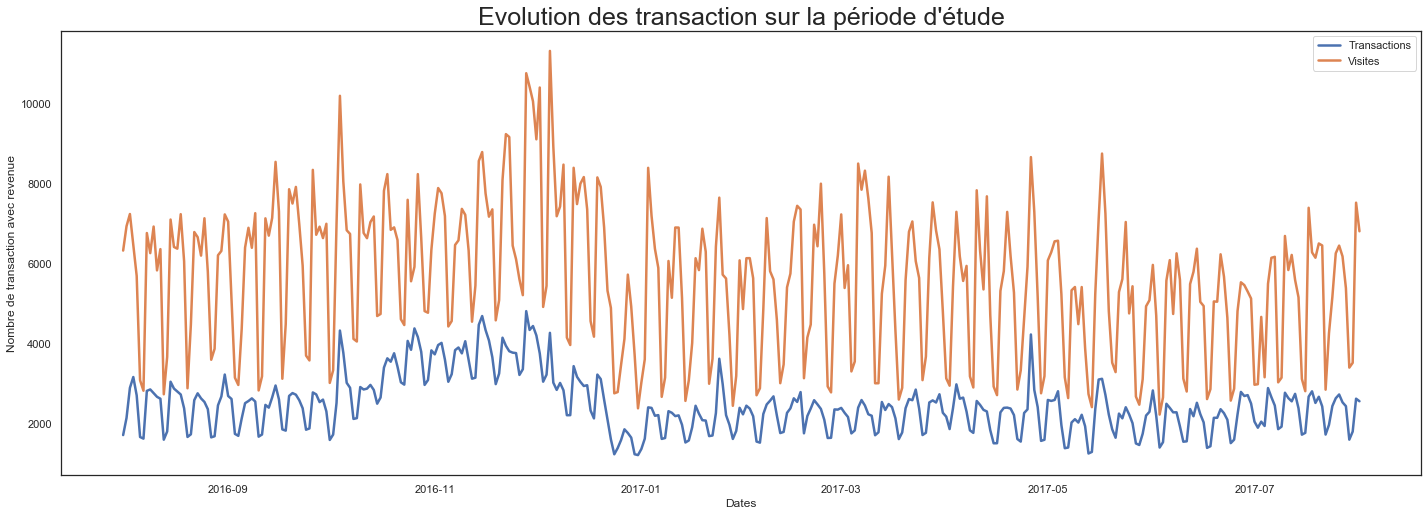

In [275]:
plt.figure(figsize = (20, 7))
sns.lineplot(data=data.groupby("date")["transactionRevenue"].count(), linewidth=2.5, label="Transactions")
sns.lineplot(data=data.groupby("date")["visitNumber"].sum(), linewidth=2.5, label="Visites")
plt.tight_layout()
plt.title("Evolution des transaction sur la période d'étude",fontsize = 25)
plt.ylabel("Nombre de transaction avec revenue")
plt.xlabel("Dates")

Le nombre de transactions est en élevé en fin novembre/décembre, ce qui correspond certainement à la période du BlackFriday et de Noël.
Globalement, il ne semble pas y avoir de tendance à la hausse sur une année.<p>
On note également que l'affluence des visites est proportionnel au nombre de transactions

In [524]:
s = data[["transactionRevenue" , "date"]].dropna()
s["transactionRevenue"] = s.transactionRevenue.astype(np.int64)
s['date'] = pd.to_datetime(data['date'], format = '%Y%m%d')
s

,transactionRevenue,date
752,37860000,2016-09-02
753,306670000,2016-09-02
799,68030000,2016-09-02
802,26250000,2016-09-02
859,574150000,2016-09-02
...,...,...
903302,335260000,2017-01-04
903305,599950000,2017-01-04
903314,30750000,2017-01-04
903315,69390000,2017-01-04


In [525]:
dd['date'] = pd.to_datetime(dd['date'], format = '%Y%m%d')
s1 = s.groupby(by=["date"],axis=0).sum()
s2 = dd[["date","visitNumber"]].groupby(by=["date"],axis=0).sum()

,transactionRevenue
date,
2016-08-01,6116060000
2016-08-02,1361190000
2016-08-04,1182890000
2016-08-05,5594260000
2016-08-06,1891040000


In [532]:
s3 = pd.concat([s1,s2],axis=1)
s3["transactionRevenue"] = s3["transactionRevenue"].fillna(0)

,transactionRevenue,visitNumber
date,,
2016-08-01,6.116060e+09,6320
2016-08-02,1.361190e+09,6929
2016-08-03,0.000000e+00,7233
2016-08-04,1.182890e+09,6456
2016-08-05,5.594260e+09,5686
...,...,...
2017-07-28,4.709440e+09,5382
2017-07-29,1.045010e+09,3396
2017-07-30,2.254160e+09,3516


Text(0.5, 1, "Evolution du nombre de visite et des transactionRevenue au cours de l'année")

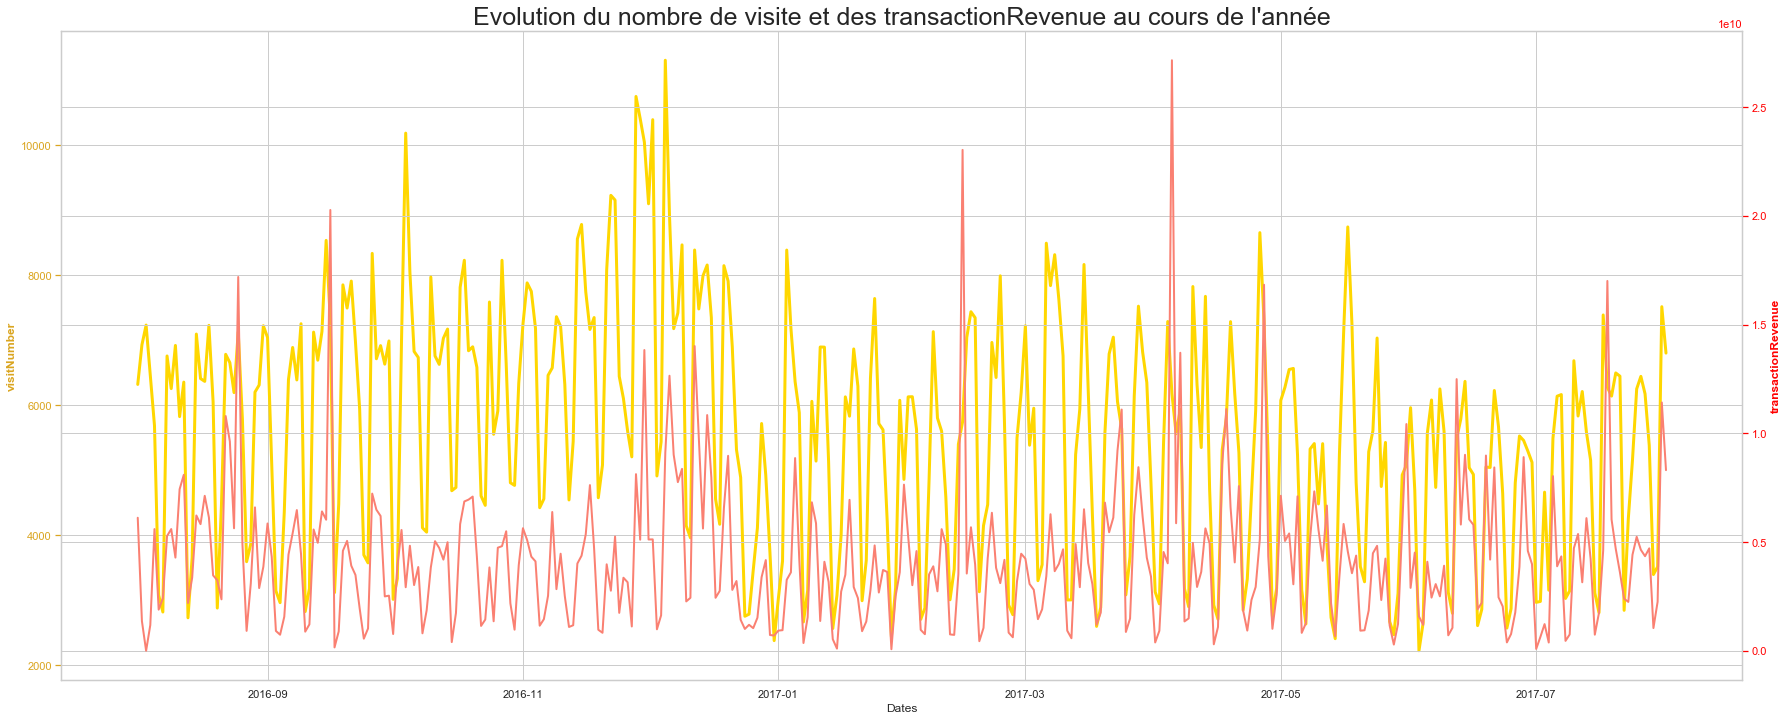

In [566]:
fig, ax1 = plt.subplots(figsize=(25,10))
t = s3.index
s4 = s3["visitNumber"]
ax1.plot(t, s4, 'gold',linewidth=3)
plt.xlabel("Dates")
ax1.set_ylabel('visitNumber', color='goldenrod',fontweight='bold')
ax1.tick_params('y', colors='goldenrod')

ax2 = ax1.twinx()
s5 = s3["transactionRevenue"]
ax2.plot(t, s5, 'salmon',linewidth=2)
ax2.set_ylabel('transactionRevenue', color='red',fontweight='bold')
ax2.tick_params('y', colors='red')
fig.tight_layout()
plt.title("Evolution du nombre de visite et des transactionRevenue au cours de l'année",fontsize = 25)

### Données technique

#### SOURCE MOBILE

In [576]:
source=data[["isMobile","transactionRevenue"]].loc[data["transactionRevenue"]>0]

In [585]:
source.groupby('isMobile')['transactionRevenue'].count()

isMobile
0    10495
1     1020
Name: transactionRevenue, dtype: int64

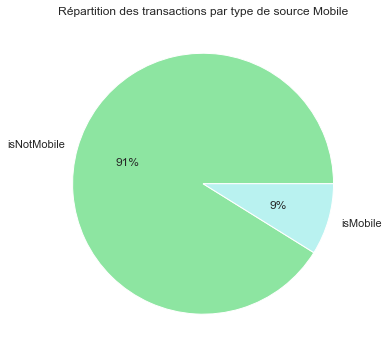

In [602]:
fig = plt.figure(figsize=(6, 6))
plt.pie(source.groupby('isMobile')['transactionRevenue'].count().values, labels = ["isNotMobile","isMobile"], colors = ["g","c"], autopct='%.0f%%')
plt.title("Répartition des transactions par type de source Mobile")
plt.show()

#### BROWSER

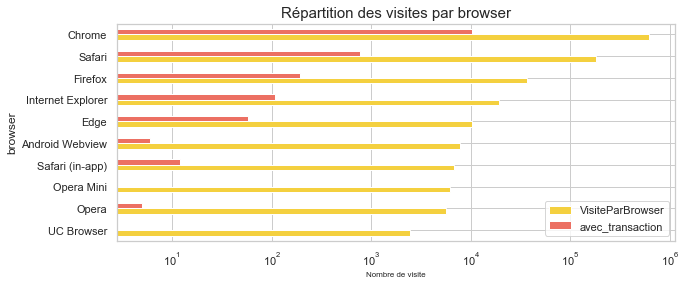

In [296]:
databrowser = data.groupby('browser')['transactionRevenue'].agg(['size','count']).sort_values(['size','count'], ascending=False).head(10)
databrowser.columns = ['VisiteParBrowser','avec_transaction',]
databrowser = databrowser.sort_values(by=['VisiteParBrowser','browser'],ascending=True)
databrowser.plot(kind='barh',logx=True,grid=True,figsize=(10,4), color=["#F4D03F","#EC7063"])
#sns.barplot(data=df_campaign,x="total",y="avec_transaction", palette="Blues_d")
plt.title("Répartition des visites par browser",fontsize = 15)
plt.xlabel('Nombre de visite',fontsize = 10)
plt.show()

#### DATA OPERATING SYSTEM

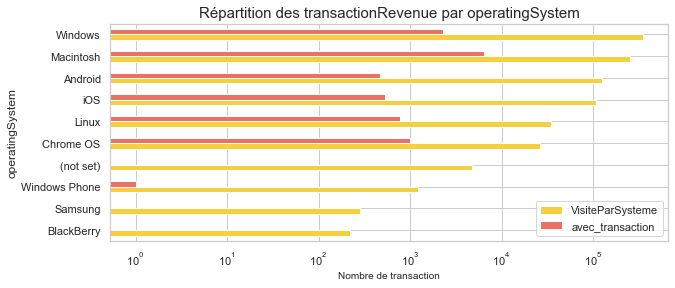

In [303]:
dataoperatingSystem = data.groupby('operatingSystem')['transactionRevenue'].agg(['size','count']).sort_values(['size','count'], ascending=False).head(10)
dataoperatingSystem.columns = ['VisiteParSysteme','avec_transaction']
dataoperatingSystem = dataoperatingSystem.sort_values(by=['VisiteParSysteme','operatingSystem'],ascending=True)
dataoperatingSystem.plot(kind='barh',logx=True,grid=True,figsize=(10,4), color=["#F4D03F","#EC7063"])
#sns.barplot(data=df_campaign,x="total",y="avec_transaction", palette="Blues_d")
plt.title("Répartition des transactionRevenue par operatingSystem",fontsize = 15)
plt.xlabel('Nombre de transaction',fontsize = 10)
plt.show()

#### DEVICE CATEGORY

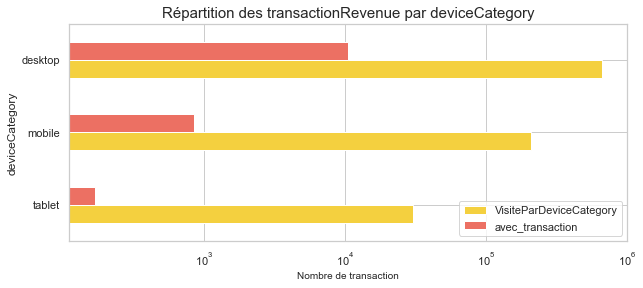

In [309]:
deviceCategory = data.groupby('deviceCategory')['transactionRevenue'].agg(['size','count']).sort_values(['size','count'], ascending=False).head(10)
deviceCategory.columns = ['VisiteParDeviceCategory','avec_transaction']
deviceCategory = deviceCategory.sort_values(by=['VisiteParDeviceCategory','deviceCategory'],ascending=True)
deviceCategory.plot(kind='barh',logx=True,grid=True,figsize=(10,4), color=["#F4D03F","#EC7063"])
#sns.barplot(data=df_campaign,x="total",y="avec_transaction", palette="Blues_d")
plt.title("Répartition des transactionRevenue par deviceCategory",fontsize = 15)
plt.xlabel('Nombre de transaction',fontsize = 10)
plt.show()

#### CHANNEL GROUPING

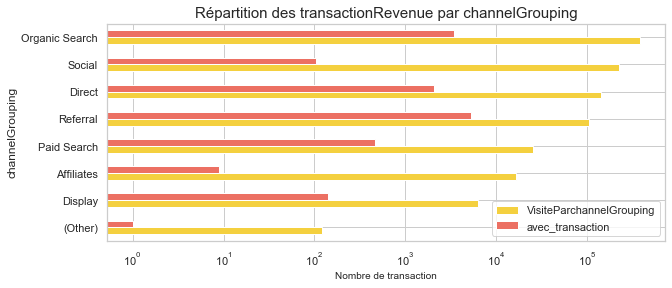

In [312]:
channelGrouping = data.groupby('channelGrouping')['transactionRevenue'].agg(['size','count']).sort_values(['size','count'], ascending=False).head(20)
channelGrouping.columns = ['VisiteParchannelGrouping','avec_transaction']
channelGrouping = channelGrouping.sort_values(by=['VisiteParchannelGrouping','channelGrouping'],ascending=True)
channelGrouping.plot(kind='barh',logx=True,grid=True,figsize=(10,4), color=["#F4D03F","#EC7063"])
#sns.barplot(data=df_campaign,x="total",y="avec_transaction", palette="Blues_d")
plt.title("Répartition des transactionRevenue par channelGrouping",fontsize = 15)
plt.xlabel('Nombre de transaction',fontsize = 10)
plt.show()

### Medium

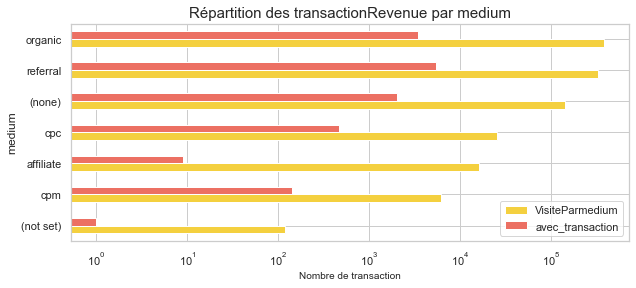

In [314]:
medium = data.groupby('medium')['transactionRevenue'].agg(['size','count']).sort_values(['size','count'], ascending=False).head(20)
medium.columns = ['VisiteParmedium','avec_transaction']
medium = medium.sort_values(by=['VisiteParmedium','medium'],ascending=True)
medium.plot(kind='barh',logx=True,grid=True,figsize=(10,4), color=["#F4D03F","#EC7063"])
#sns.barplot(data=df_campaign,x="total",y="avec_transaction", palette="Blues_d")
plt.title("Répartition des transactionRevenue par medium",fontsize = 15)
plt.xlabel('Nombre de transaction',fontsize = 10)
plt.show()

### Sources

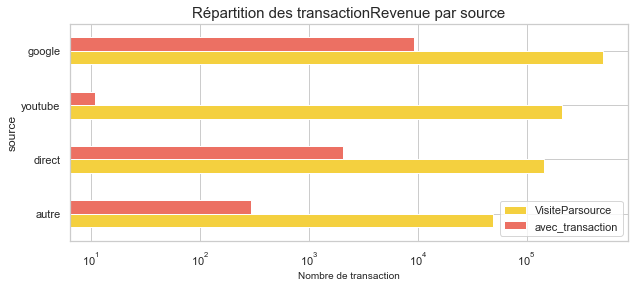

In [323]:
source = data.groupby('source')['transactionRevenue'].agg(['size','count']).sort_values(['size','count'], ascending=False).head(10)
source.columns = ['VisiteParsource','avec_transaction']
source = source.sort_values(by=['VisiteParsource','source'],ascending=True)
source.plot(kind='barh',logx=True,grid=True,figsize=(10,4), color=["#F4D03F","#EC7063"])
#sns.barplot(data=df_campaign,x="total",y="avec_transaction", palette="Blues_d")
plt.title("Répartition des transactionRevenue par source",fontsize = 15)
plt.xlabel('Nombre de transaction',fontsize = 10)
plt.show()

In [452]:
def is_number_tryexcept(s):
    try:
        float(s[1])
        return True
    except ValueError:
        return False
    
is_number_tryexcept(data['fullVisitorId'])

True

In [453]:
liste_categorique=["source","medium","subContinent","channelGrouping","operatingSystem","browser","deviceCategory","Journée"]    

In [454]:
liste=[]
for i in liste_categorique:
    onehotencoder_1 = OneHotEncoder(handle_unknown = 'ignore').fit(np.array(data[i]).reshape(-1, 1))
    data[onehotencoder_1.categories_[0]] = onehotencoder_1.transform(np.array(data[i]).reshape(-1, 1)).toarray().astype(int)
    data=data.drop([i],axis=1)

In [455]:
data

,transactionRevenueTotal,NombreVisiteavecRevenue,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,hits,transactionRevenue,continent,...,desktop,mobile,tablet,Dimanche,Jeudi,Lundi,Mardi,Mercredi,Samedi,Vendredi
0,0.0,0,1131660440785968503,1131660440785968503_1472830385,1472830385,1,2016-09-02 15:33:05,1,0.0,Asia,...,1,0,0,0,0,0,0,0,0,1
1,0.0,0,377306020877927890,377306020877927890_1472880147,1472880147,1,2016-09-03 05:22:27,1,0.0,Oceania,...,1,0,0,0,0,0,0,0,0,1
2,0.0,0,3895546263509774583,3895546263509774583_1472865386,1472865386,1,2016-09-03 01:16:26,1,0.0,Europe,...,1,0,0,0,0,0,0,0,0,1
3,0.0,0,4763447161404445595,4763447161404445595_1472881213,1472881213,1,2016-09-03 05:40:13,1,0.0,Asia,...,1,0,0,0,0,0,0,0,0,1
4,0.0,0,27294437909732085,27294437909732085_1472822600,1472822600,2,2016-09-02 13:23:20,1,0.0,Europe,...,0,1,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
903648,0.0,0,567297396362985009,567297396362985009_1483581760,1483581760,1,2017-01-05 02:02:40,15,0.0,Oceania,...,0,0,1,0,0,0,0,1,0,0
903649,0.0,0,2140149974339316233,2140149974339316233_1483557808,1483557808,1,2017-01-04 19:23:28,16,0.0,Africa,...,1,0,0,0,0,0,0,1,0,0
903650,0.0,0,5123779100307500332,5123779100307500332_1483554750,1483554750,1,2017-01-04 18:32:30,17,0.0,Americas,...,1,0,0,0,0,0,0,1,0,0
903651,0.0,0,7231728964973959842,7231728964973959842_1483543798,1483543798,1,2017-01-04 15:29:58,18,0.0,Asia,...,0,1,0,0,0,0,0,1,0,0


In [456]:
data["isMobile"] =data["isMobile"] *1
data["isTrueDirect"] =data["isTrueDirect"] *1

In [457]:
data["newVisits"] = data["newVisits"].fillna(0)
data["bounces"] = data["bounces"].fillna(0)
data["isTrueDirect"] = data["isTrueDirect"].fillna(0)

# Modèles

In [459]:
y = data['transactionRevenueTotal']
X = data.drop(['continent','visitStartTime','transactionRevenue','visitId','date','transactionRevenueTotal','fullVisitorId','sessionId','visitId'],axis=1)

In [368]:
splits = np.round(np.linspace(0.4,0.6,3),2)

In [369]:
res = pd.DataFrame({"Methode" : [],
                    "Modèle" : [],
                    "Paramètres" : [],
                    "R2_train" : [],
                    "R2_test" : []
                   })

### DecisionTreeRegressor

In [460]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
import random

depth = np.round(np.linspace(1, 10, 10))

for s in splits :
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = s, shuffle = True, random_state=1)
    param_done = []
    for _ in range (depth.size//2) :
        d = depth[random.randint(0,depth.size - 1)]
        while d in param_done :
            d = depth[random.randint(0,depth.size - 1)]
        param_done.append(d)  
        dtr = DecisionTreeRegressor(max_depth = d, random_state=1).fit(X,y)
        dtr_pred_train = dtr.predict(X_train)
        dtr_pred_test = dtr.predict(X_test)
        score_train = np.round(dtr.score(X_train,y_train),6)
        score_test = np.round(dtr.score(X_test,y_test),6)
        res=res.append({"Methode" : "DecisionTreeRegressor",
                    "Modèle" : dtr,
                    "Paramètres" : {"split" : s,"depth" : d},
                    "R2_train" : score_train,
                    "R2_test" : score_test
                   }, ignore_index=True )

### BaggingRegressor

In [461]:
from sklearn.ensemble import BaggingRegressor

n_estimators= np.round(np.linspace(10, 60, 6))

for s in splits :
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = s, shuffle = True, random_state=1)
    param_done = []
    for _ in range (n_estimators.size//2) :
        n = n_estimators[random.randint(0,n_estimators.size - 1)]
        while n in param_done :
            n = n_estimators[random.randint(0,n_estimators.size - 1)]
        param_done.append(n)  
        br = BaggingRegressor(n_estimators=int(n)).fit(X,y)
        br_pred_train = br.predict(X_train)
        br_pred_test = br.predict(X_test)
        score_train = np.round(br.score(X_train,y_train),6)
        score_test = np.round(br.score(X_test,y_test),6)        
        res=res.append({"Methode" : "BaggingRegressor",
                    "Modèle" : br,
                    "Paramètres" : {"split" : s,"n_estimators" : n},
                    "R2_train" : score_train,
                    "R2_test" : score_test
                   }, ignore_index=True )

### GradientBoostingRegressor

In [463]:
from sklearn.ensemble import GradientBoostingRegressor

n_estimators= np.round(np.linspace(40, 120, 5))  
alphas = np.round(np.linspace(0, 2,100),2)
l1_ratios = np.round(np.linspace(0,1,101),2)

for s in splits :
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = s, shuffle = True, random_state=1)
    param_done = []
    for _ in range ((alphas.size * l1_ratios.size * n_estimators.size)//5000) :
        n = n_estimators[random.randint(0,n_estimators.size - 1)]        
        a = alphas[random.randint(0,alphas.size - 1)]
        l = l1_ratios[random.randint(0,l1_ratios.size - 1)]
        while (a,l,n) in param_done :
            a = alphas[random.randint(0,alphas.size - 1)]
            l = l1_ratios[random.randint(0,l1_ratios.size - 1)]
            n = n_estimators[random.randint(0,n_estimators.size - 1)]
        param_done.append((a,l,n))  
        gbr = GradientBoostingRegressor(n_estimators=int(n)).fit(X,y)
        gbr_pred_train = gbr.predict(X_train)
        gbr_pred_test = gbr.predict(X_test)
        score_train = np.round(gbr.score(X_train,y_train),6)
        score_test = np.round(gbr.score(X_test,y_test),6)        
        res=res.append({"Methode" : "GradientBoostingRegressor",
                    "Modèle" : gbr,
                    "Paramètres" : {"split" : s,"alpha" : a,"l1_ratios" : l,"n_estimators" : n},
                    "R2_train" : score_train,
                    "R2_test" : score_test
                   }, ignore_index=True )

### RandomForestRegressor

In [464]:
from sklearn.ensemble import RandomForestRegressor

n_estimators= np.round(np.linspace(40, 120, 5))  
depth = np.round(np.linspace(1, 10, 10))

for s in splits :
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = s, shuffle = True, random_state=1)
    param_done = []
    for _ in range ((depth.size * n_estimators.size)//5) :
        n = n_estimators[random.randint(0,n_estimators.size - 1)]        
        d = depth[random.randint(0,depth.size - 1)]
        while (d,n) in param_done :
            d = depth[random.randint(0,depth.size - 1)]
            n = n_estimators[random.randint(0,n_estimators.size - 1)]
        param_done.append((d,n))  
        rfr = RandomForestRegressor(n_estimators=int(n),max_depth=d).fit(X,y)
        rfr_pred_train = rfr.predict(X_train)
        rfr_pred_test = rfr.predict(X_test)
        score_train = np.round(rfr.score(X_train,y_train),6)
        score_test = np.round(rfr.score(X_test,y_test),6)        
        res=res.append({"Methode" : "RandomForestRegressor",
                    "Modèle" : rfr,
                    "Paramètres" : {"split" : s,"max_depth" : d,"n_estimators" : n},
                    "R2_train" : score_train,
                    "R2_test" : score_test
                   }, ignore_index=True )

In [465]:
res.sort_values(by="R2_test",ascending=False).reset_index(drop=True)

,Methode,Modèle,Paramètres,R2_train,R2_test
0,BaggingRegressor,"(DecisionTreeRegressor(criterion='mse', max_de...","{'split': 0.4, 'n_estimators': 50.0}",0.999626,0.999672
1,BaggingRegressor,"(DecisionTreeRegressor(criterion='mse', max_de...","{'split': 0.4, 'n_estimators': 40.0}",0.999601,0.999642
2,BaggingRegressor,"(DecisionTreeRegressor(criterion='mse', max_de...","{'split': 0.6, 'n_estimators': 40.0}",0.999576,0.999623
3,BaggingRegressor,"(DecisionTreeRegressor(criterion='mse', max_de...","{'split': 0.4, 'n_estimators': 30.0}",0.999586,0.999619
4,BaggingRegressor,"(DecisionTreeRegressor(criterion='mse', max_de...","{'split': 0.6, 'n_estimators': 30.0}",0.999586,0.999613
...,...,...,...,...,...
79,RandomForestRegressor,"(DecisionTreeRegressor(criterion='mse', max_de...","{'split': 0.6, 'max_depth': 1.0, 'n_estimators...",0.982753,0.980126
80,RandomForestRegressor,"(DecisionTreeRegressor(criterion='mse', max_de...","{'split': 0.6, 'max_depth': 1.0, 'n_estimators...",0.982753,0.980126
81,RandomForestRegressor,"(DecisionTreeRegressor(criterion='mse', max_de...","{'split': 0.4, 'max_depth': 1.0, 'n_estimators...",0.982506,0.978987
82,DecisionTreeRegressor,"DecisionTreeRegressor(criterion='mse', max_dep...","{'split': 0.4, 'depth': 1.0}",0.982506,0.978987


Le meilleur modèle est le Bagging Regressor avec comme split 40% et le nombre d'estimateurs fixé à 50.

In [468]:
final_model = BaggingRegressor(n_estimators = 50).fit(X,y)

In [472]:
final_model_score = 0.999672

In [471]:
feature_importances = np.mean([
    tree.feature_importances_ for tree in final_model.estimators_
], axis=0)

In [485]:
features = pd.DataFrame(np.mean([tree.feature_importances_ for tree in final_model.estimators_], axis=0),X_train.columns,columns=['Importance'])
features=features.sort_values("Importance",ascending=False)
features = features.loc[features['Importance']>0]

,Importance
NombreVisiteTotal,0.984537
NombreVisiteavecRevenue,0.009513
visitStartMonth,0.000931
Windows,0.000677
hits,0.000539
visitStartDay,0.000410
visitNumber,0.000346
pageviews,0.000328
Macintosh,0.000324
Referral,0.000301


Le nombre de visite total est la variable qui a la plus grande importance pour la prédiction de la target

In [505]:
f = f.drop("visitStartMonth")

En supprimant les variables liées aux visites et aux dates, nous allons voir l'importance des variables suivantes

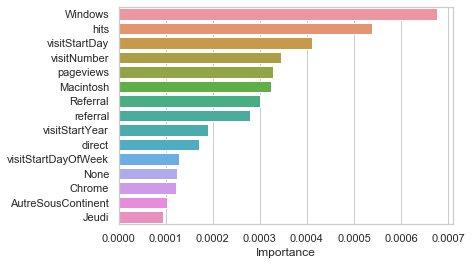

In [514]:
sns.barplot(x=f["Importance"].head(15),y=f.head(15).index)